In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 1

In [3]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [5]:
ϕ_list = np.load("v_list_1.npy")
ems_list = np.load("e_list_1.npy")

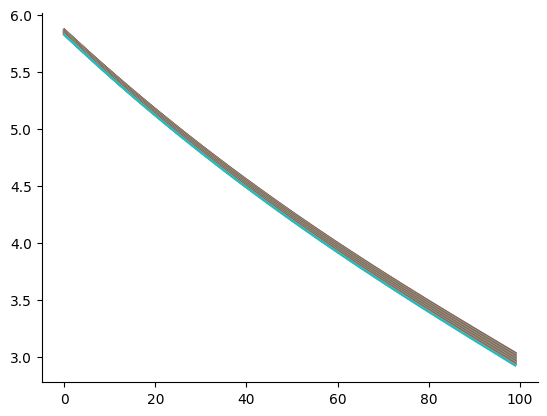

In [6]:
loc_start = np.abs(y2_grid - np.mean(θ_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(θ_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(θ_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

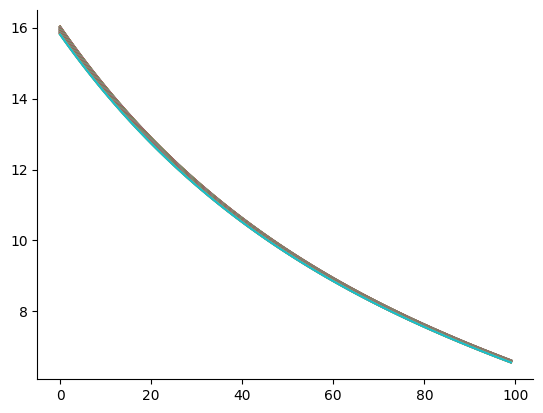

In [7]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [10]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.2
max_iter = 5000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.9
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.114381692020	 rhs error: 0.127686743587
Episode: 2	 lhs error: 0.117957156374	 rhs error: 0.129814940452
Episode: 3	 lhs error: 0.116107361752	 rhs error: 0.126563767317
Episode: 4	 lhs error: 0.111422132288	 rhs error: 0.121492243137
Episode: 5	 lhs error: 0.108156249511	 rhs error: 0.116071949399
Episode: 6	 lhs error: 0.103019265275	 rhs error: 0.110800324339
Episode: 7	 lhs error: 0.100113402841	 rhs error: 0.106007684276
Episode: 8	 lhs error: 0.096642225604	 rhs error: 0.101729750055
Episode: 9	 lhs error: 0.094355647920	 rhs error: 0.097976359486
Episode: 10	 lhs error: 0.090664713209	 rhs error: 0.094741764381
Episode: 11	 lhs error: 0.088326488820	 rhs error: 0.091976568087
Episode: 12	 lhs error: 0.087590592410	 rhs error: 0.089557538117
Episode: 13	 lhs error: 0.084848305696	 rhs error: 0.087525605325
Episode: 14	 lhs error: 0.083500600133	 rhs error: 0.085756256454
Episode: 15	 lhs error: 0.082355214759	 rhs error: 0.084292988556
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.023440203497	 rhs error: 0.023718759732
Episode: 126	 lhs error: 0.023173653192	 rhs error: 0.023466179107
Episode: 127	 lhs error: 0.022896437748	 rhs error: 0.023200772210
Episode: 128	 lhs error: 0.022610370205	 rhs error: 0.022924958185
Episode: 129	 lhs error: 0.022316721852	 rhs error: 0.022640513116
Episode: 130	 lhs error: 0.022016294882	 rhs error: 0.022348625730
Episode: 131	 lhs error: 0.021709700067	 rhs error: 0.022050039048
Episode: 132	 lhs error: 0.021397377861	 rhs error: 0.021745229251
Episode: 133	 lhs error: 0.021344185884	 rhs error: 0.021467035646
Episode: 134	 lhs error: 0.021288143653	 rhs error: 0.021431018001
Episode: 135	 lhs error: 0.021211838706	 rhs error: 0.021371031914
Episode: 136	 lhs error: 0.021118895884	 rhs error: 0.021290714947
Episode: 137	 lhs error: 0.021012610458	 rhs error: 0.021193615367
Episode: 138	 lhs error: 0.020895739286	 rhs error: 0.021082951336
Episode: 139	 lhs error: 0.020770454855	 rhs error: 0.02096144

Episode: 249	 lhs error: 0.010113287763	 rhs error: 0.019849673627
Episode: 250	 lhs error: 0.010036403373	 rhs error: 0.019868078869
Episode: 251	 lhs error: 0.009956127475	 rhs error: 0.019868230666
Episode: 252	 lhs error: 0.009901380235	 rhs error: 0.019899363887
Episode: 253	 lhs error: 0.009876976983	 rhs error: 0.019966227370
Episode: 254	 lhs error: 0.009851845645	 rhs error: 0.020040626531
Episode: 255	 lhs error: 0.009825389167	 rhs error: 0.020116835009
Episode: 256	 lhs error: 0.009797027442	 rhs error: 0.020191486730
Episode: 257	 lhs error: 0.009766403779	 rhs error: 0.020263294499
Episode: 258	 lhs error: 0.009733387484	 rhs error: 0.020332039364
Episode: 259	 lhs error: 0.009698007512	 rhs error: 0.020397880711
Episode: 260	 lhs error: 0.009660364533	 rhs error: 0.020461053166
Episode: 261	 lhs error: 0.009620588435	 rhs error: 0.020521775466
Episode: 262	 lhs error: 0.009578793485	 rhs error: 0.020580221991
Episode: 263	 lhs error: 0.009535092358	 rhs error: 0.02063655

Episode: 373	 lhs error: 0.006044584690	 rhs error: 0.023443148584
Episode: 374	 lhs error: 0.006021588659	 rhs error: 0.023451044666
Episode: 375	 lhs error: 0.005998187005	 rhs error: 0.023458683416
Episode: 376	 lhs error: 0.005974404112	 rhs error: 0.023466103038
Episode: 377	 lhs error: 0.005950261896	 rhs error: 0.023473327446
Episode: 378	 lhs error: 0.005925777728	 rhs error: 0.023480340679
Episode: 379	 lhs error: 0.005900947324	 rhs error: 0.023487183146
Episode: 380	 lhs error: 0.005875782213	 rhs error: 0.023493815722
Episode: 381	 lhs error: 0.005850263540	 rhs error: 0.023500268186
Episode: 382	 lhs error: 0.005824385542	 rhs error: 0.023506532937
Episode: 383	 lhs error: 0.005810313643	 rhs error: 0.023512597453
Episode: 384	 lhs error: 0.005799959463	 rhs error: 0.023518418706
Episode: 385	 lhs error: 0.005788786707	 rhs error: 0.023523993053
Episode: 386	 lhs error: 0.005776781311	 rhs error: 0.023529294559
Episode: 387	 lhs error: 0.005763930432	 rhs error: 0.02353432

Episode: 497	 lhs error: 0.004033767974	 rhs error: 0.023846567487
Episode: 498	 lhs error: 0.004022052710	 rhs error: 0.023855325605
Episode: 499	 lhs error: 0.004009862887	 rhs error: 0.023864177996
Episode: 500	 lhs error: 0.003997176742	 rhs error: 0.023872377830
Episode: 501	 lhs error: 0.003984035538	 rhs error: 0.023881208478
Episode: 502	 lhs error: 0.003970465232	 rhs error: 0.023889636278
Episode: 503	 lhs error: 0.003956445470	 rhs error: 0.023897893855
Episode: 504	 lhs error: 0.003942006603	 rhs error: 0.023906398234
Episode: 505	 lhs error: 0.003927124455	 rhs error: 0.023915109926
Episode: 506	 lhs error: 0.003911864192	 rhs error: 0.023923523256
Episode: 507	 lhs error: 0.003896215830	 rhs error: 0.023931517231
Episode: 508	 lhs error: 0.003880152541	 rhs error: 0.023939659442
Episode: 509	 lhs error: 0.003863781743	 rhs error: 0.023947566443
Episode: 510	 lhs error: 0.003852894815	 rhs error: 0.023955348714
Episode: 511	 lhs error: 0.003843173890	 rhs error: 0.02396318

Episode: 621	 lhs error: 0.002820302087	 rhs error: 0.023553328446
Episode: 622	 lhs error: 0.002796283084	 rhs error: 0.023813784561
Episode: 623	 lhs error: 0.002797383145	 rhs error: 0.023570071040
Episode: 624	 lhs error: 0.002765816904	 rhs error: 0.023512692198
Episode: 625	 lhs error: 0.002766053757	 rhs error: 0.023570680520
Episode: 626	 lhs error: 0.002765942599	 rhs error: 0.023578773716
Episode: 627	 lhs error: 0.002755899195	 rhs error: 0.023553096651
Episode: 628	 lhs error: 0.002749187293	 rhs error: 0.023560886337
Episode: 629	 lhs error: 0.002744435918	 rhs error: 0.023568798049
Episode: 630	 lhs error: 0.002722739070	 rhs error: 0.023580966815
Episode: 631	 lhs error: 0.002733460585	 rhs error: 0.023283712970
Episode: 632	 lhs error: 0.002701638793	 rhs error: 0.023295309186
Episode: 633	 lhs error: 0.002714146411	 rhs error: 0.023267815177
Episode: 634	 lhs error: 0.002701769752	 rhs error: 0.023408052755
Episode: 635	 lhs error: 0.002700672035	 rhs error: 0.02364084

Episode: 745	 lhs error: 0.002028956741	 rhs error: 0.023627213458
Episode: 746	 lhs error: 0.002022950093	 rhs error: 0.023626501794
Episode: 747	 lhs error: 0.002016688365	 rhs error: 0.023625308722
Episode: 748	 lhs error: 0.002010070378	 rhs error: 0.023623909240
Episode: 749	 lhs error: 0.002002304988	 rhs error: 0.023622245173
Episode: 750	 lhs error: 0.001995845415	 rhs error: 0.023620291843
Episode: 751	 lhs error: 0.001989247075	 rhs error: 0.023617640956
Episode: 752	 lhs error: 0.001982255359	 rhs error: 0.023615343033
Episode: 753	 lhs error: 0.001973078144	 rhs error: 0.023612930485
Episode: 754	 lhs error: 0.001967355663	 rhs error: 0.023610357178
Episode: 755	 lhs error: 0.001959501377	 rhs error: 0.023607044562
Episode: 756	 lhs error: 0.001950950357	 rhs error: 0.023603866489
Episode: 757	 lhs error: 0.002005371461	 rhs error: 0.023598347464
Episode: 758	 lhs error: 0.001889207271	 rhs error: 0.023606425413
Episode: 759	 lhs error: 0.001987755690	 rhs error: 0.02358780

Episode: 869	 lhs error: 0.001437077070	 rhs error: 0.023690667621
Episode: 870	 lhs error: 0.001433770641	 rhs error: 0.023692390581
Episode: 871	 lhs error: 0.001430482140	 rhs error: 0.023694096742
Episode: 872	 lhs error: 0.001427032308	 rhs error: 0.023695803609
Episode: 873	 lhs error: 0.001423577543	 rhs error: 0.023697459644
Episode: 874	 lhs error: 0.001419990905	 rhs error: 0.023699238375
Episode: 875	 lhs error: 0.001416628340	 rhs error: 0.023700895601
Episode: 876	 lhs error: 0.001413911196	 rhs error: 0.023702749255
Episode: 877	 lhs error: 0.001411303744	 rhs error: 0.023704372677
Episode: 878	 lhs error: 0.001403190628	 rhs error: 0.023706561090
Episode: 879	 lhs error: 0.001412293723	 rhs error: 0.023690691033
Episode: 880	 lhs error: 0.001403767977	 rhs error: 0.023684257785
Episode: 881	 lhs error: 0.001399554186	 rhs error: 0.023703002103
Episode: 882	 lhs error: 0.001395988696	 rhs error: 0.023711113427
Episode: 883	 lhs error: 0.001392959005	 rhs error: 0.02371425

Episode: 993	 lhs error: 0.000722647602	 rhs error: 0.023887025948
Episode: 994	 lhs error: 0.000762744767	 rhs error: 0.023839966068
Episode: 995	 lhs error: 0.000755840652	 rhs error: 0.023869393331
Episode: 996	 lhs error: 0.000749230993	 rhs error: 0.023878223572
Episode: 997	 lhs error: 0.000743526420	 rhs error: 0.023879319445
Episode: 998	 lhs error: 0.000737678318	 rhs error: 0.023879161147
Episode: 999	 lhs error: 0.000731502095	 rhs error: 0.023878320389
Episode: 1000	 lhs error: 0.000725606948	 rhs error: 0.023877679982
Episode: 1001	 lhs error: 0.000719680313	 rhs error: 0.023876645327
Episode: 1002	 lhs error: 0.000713766234	 rhs error: 0.023875552792
Episode: 1003	 lhs error: 0.000707695929	 rhs error: 0.023874374796
Episode: 1004	 lhs error: 0.000701843500	 rhs error: 0.023873025667
Episode: 1005	 lhs error: 0.000696132452	 rhs error: 0.023871389033
Episode: 1006	 lhs error: 0.000689990765	 rhs error: 0.023869974055
Episode: 1007	 lhs error: 0.000684180848	 rhs error: 0.

Episode: 1116	 lhs error: 0.000221619013	 rhs error: 0.023709367357
Episode: 1117	 lhs error: 0.000219156022	 rhs error: 0.023708476413
Episode: 1118	 lhs error: 0.000216250804	 rhs error: 0.023707366311
Episode: 1119	 lhs error: 0.000213296955	 rhs error: 0.023708022974
Episode: 1120	 lhs error: 0.000210834686	 rhs error: 0.023706546348
Episode: 1121	 lhs error: 0.000208217862	 rhs error: 0.023705525966
Episode: 1122	 lhs error: 0.000205719950	 rhs error: 0.023705232274
Episode: 1123	 lhs error: 0.000203042898	 rhs error: 0.023704086252
Episode: 1124	 lhs error: 0.000200368520	 rhs error: 0.023703821777
Episode: 1125	 lhs error: 0.000197926437	 rhs error: 0.023703303850
Episode: 1126	 lhs error: 0.000195914863	 rhs error: 0.023701143169
Episode: 1127	 lhs error: 0.000193445591	 rhs error: 0.023700256842
Episode: 1128	 lhs error: 0.000190730796	 rhs error: 0.023700986889
Episode: 1129	 lhs error: 0.000188312984	 rhs error: 0.023700748467
Episode: 1130	 lhs error: 0.000186006623	 rhs er

Episode: 1240	 lhs error: 0.000040940296	 rhs error: 0.023687757518
Episode: 1241	 lhs error: 0.000040341241	 rhs error: 0.023688342744
Episode: 1242	 lhs error: 0.000039795020	 rhs error: 0.023687859490
Episode: 1243	 lhs error: 0.000039437697	 rhs error: 0.023687638475
Episode: 1244	 lhs error: 0.000038790856	 rhs error: 0.023687908410
Episode: 1245	 lhs error: 0.000038478487	 rhs error: 0.023687741649
Episode: 1246	 lhs error: 0.000037972026	 rhs error: 0.023687599282
Episode: 1247	 lhs error: 0.000037563364	 rhs error: 0.023687872671
Episode: 1248	 lhs error: 0.000037061949	 rhs error: 0.023688101073
Episode: 1249	 lhs error: 0.000036458139	 rhs error: 0.023688494512
Episode: 1250	 lhs error: 0.000035888496	 rhs error: 0.023688906402
Episode: 1251	 lhs error: 0.000035490333	 rhs error: 0.023688807772
Episode: 1252	 lhs error: 0.000034946897	 rhs error: 0.023688363152
Episode: 1253	 lhs error: 0.000034640754	 rhs error: 0.023688136778
Episode: 1254	 lhs error: 0.000034274932	 rhs er

Episode: 1364	 lhs error: 0.000021078098	 rhs error: 0.023689788863
Episode: 1365	 lhs error: 0.000020876340	 rhs error: 0.023689836923
Episode: 1366	 lhs error: 0.000020838952	 rhs error: 0.023690744764
Episode: 1367	 lhs error: 0.000020932859	 rhs error: 0.023689865103
Episode: 1368	 lhs error: 0.000020846906	 rhs error: 0.023690198020
Episode: 1369	 lhs error: 0.000020726025	 rhs error: 0.023691003228
Episode: 1370	 lhs error: 0.000020637850	 rhs error: 0.023691277086
Episode: 1371	 lhs error: 0.000020627801	 rhs error: 0.023690638319
Episode: 1372	 lhs error: 0.000020514937	 rhs error: 0.023690334565
Episode: 1373	 lhs error: 0.000020532214	 rhs error: 0.023690152878
Episode: 1374	 lhs error: 0.000020312501	 rhs error: 0.023690359027
Episode: 1375	 lhs error: 0.000020540682	 rhs error: 0.023689916082
Episode: 1376	 lhs error: 0.000020489684	 rhs error: 0.023688860646
Episode: 1377	 lhs error: 0.000020342087	 rhs error: 0.023690128677
Episode: 1378	 lhs error: 0.000020355285	 rhs er

Episode: 1488	 lhs error: 0.000014683304	 rhs error: 0.023692223688
Episode: 1489	 lhs error: 0.000014666209	 rhs error: 0.023693850593
Episode: 1490	 lhs error: 0.000014617421	 rhs error: 0.023693424524
Episode: 1491	 lhs error: 0.000014569593	 rhs error: 0.023692728900
Episode: 1492	 lhs error: 0.000014539603	 rhs error: 0.023692098939
Episode: 1493	 lhs error: 0.000014506029	 rhs error: 0.023692863208
Episode: 1494	 lhs error: 0.000014477376	 rhs error: 0.023692983806
Episode: 1495	 lhs error: 0.000014428655	 rhs error: 0.023692895481
Episode: 1496	 lhs error: 0.000014369372	 rhs error: 0.023692334445
Episode: 1497	 lhs error: 0.000014341493	 rhs error: 0.023692533080
Episode: 1498	 lhs error: 0.000014300836	 rhs error: 0.023692511931
Episode: 1499	 lhs error: 0.000014270072	 rhs error: 0.023693142131
Episode: 1500	 lhs error: 0.000014231540	 rhs error: 0.023692871225
Episode: 1501	 lhs error: 0.000014164527	 rhs error: 0.023692658806
Episode: 1502	 lhs error: 0.000014097926	 rhs er

Episode: 1612	 lhs error: 0.000010272367	 rhs error: 0.023692661484
Episode: 1613	 lhs error: 0.000010255199	 rhs error: 0.023693397629
Episode: 1614	 lhs error: 0.000010461212	 rhs error: 0.023693653645
Episode: 1615	 lhs error: 0.000010415821	 rhs error: 0.023694312698
Episode: 1616	 lhs error: 0.000010305382	 rhs error: 0.023693612422
Episode: 1617	 lhs error: 0.000010297769	 rhs error: 0.023693702905
Episode: 1618	 lhs error: 0.000010248087	 rhs error: 0.023693202327
Episode: 1619	 lhs error: 0.000010201982	 rhs error: 0.023693935064
Episode: 1620	 lhs error: 0.000010253095	 rhs error: 0.023693582450
Episode: 1621	 lhs error: 0.000010375773	 rhs error: 0.023694506660
Episode: 1622	 lhs error: 0.000010272758	 rhs error: 0.023694373174
Episode: 1623	 lhs error: 0.000010193400	 rhs error: 0.023693339836
Episode: 1624	 lhs error: 0.000009980599	 rhs error: 0.023692428546
Episode: 1625	 lhs error: 0.000010150658	 rhs error: 0.023693069174
Episode: 1626	 lhs error: 0.000010124750	 rhs er

Episode: 1736	 lhs error: 0.000007883545	 rhs error: 0.023689297136
Episode: 1737	 lhs error: 0.000007768028	 rhs error: 0.023688406794
Episode: 1738	 lhs error: 0.000007758464	 rhs error: 0.023688495266
Episode: 1739	 lhs error: 0.000007732434	 rhs error: 0.023689208094
Episode: 1740	 lhs error: 0.000007613329	 rhs error: 0.023688881315
Episode: 1741	 lhs error: 0.000007746414	 rhs error: 0.023689506346
Episode: 1742	 lhs error: 0.000007809585	 rhs error: 0.023690389680
Episode: 1743	 lhs error: 0.000009600234	 rhs error: 0.023689816797
Episode: 1744	 lhs error: 0.000007339780	 rhs error: 0.023687733664
Episode: 1745	 lhs error: 0.000007665305	 rhs error: 0.023687311098
Episode: 1746	 lhs error: 0.000007448639	 rhs error: 0.023688203329
Episode: 1747	 lhs error: 0.000008064716	 rhs error: 0.023687986417
Episode: 1748	 lhs error: 0.000007726856	 rhs error: 0.023689854379
Episode: 1749	 lhs error: 0.000007426569	 rhs error: 0.023689555996
Episode: 1750	 lhs error: 0.000007217210	 rhs er

Episode: 1860	 lhs error: 0.000003278636	 rhs error: 0.023688363615
Episode: 1861	 lhs error: 0.000003384773	 rhs error: 0.023688508366
Episode: 1862	 lhs error: 0.000005487673	 rhs error: 0.023688457835
Episode: 1863	 lhs error: 0.000005137706	 rhs error: 0.023687115314
Episode: 1864	 lhs error: 0.000003385782	 rhs error: 0.023688187562
Episode: 1865	 lhs error: 0.000003186942	 rhs error: 0.023688161217
Episode: 1866	 lhs error: 0.000003257416	 rhs error: 0.023688046185
Episode: 1867	 lhs error: 0.000003216441	 rhs error: 0.023688405989
Episode: 1868	 lhs error: 0.000003651397	 rhs error: 0.023688715530
Episode: 1869	 lhs error: 0.000003213720	 rhs error: 0.023687800470
Episode: 1870	 lhs error: 0.000003788311	 rhs error: 0.023687472174
Episode: 1871	 lhs error: 0.000004056939	 rhs error: 0.023687885262
Episode: 1872	 lhs error: 0.000005935288	 rhs error: 0.023688398362
Episode: 1873	 lhs error: 0.000003464837	 rhs error: 0.023689634336
Episode: 1874	 lhs error: 0.000002807346	 rhs er

Episode: 1984	 lhs error: 0.000003510858	 rhs error: 0.023689075774
Episode: 1985	 lhs error: 0.000002867122	 rhs error: 0.023689747743
Episode: 1986	 lhs error: 0.000004111459	 rhs error: 0.023689384550
Episode: 1987	 lhs error: 0.000005839193	 rhs error: 0.023690223077
Episode: 1988	 lhs error: 0.000002306132	 rhs error: 0.023688831534
Episode: 1989	 lhs error: 0.000002032972	 rhs error: 0.023688942499
Episode: 1990	 lhs error: 0.000005358340	 rhs error: 0.023688699938
Episode: 1991	 lhs error: 0.000001735788	 rhs error: 0.023689869582
Episode: 1992	 lhs error: 0.000002077229	 rhs error: 0.023689524843
Episode: 1993	 lhs error: 0.000002402401	 rhs error: 0.023689838573
Episode: 1994	 lhs error: 0.000004719573	 rhs error: 0.023690160718
Episode: 1995	 lhs error: 0.000002230831	 rhs error: 0.023691154289
Episode: 1996	 lhs error: 0.000000949521	 rhs error: 0.023690581741


In [11]:
np.save(f"ems_{λ}_{y_lower}", ems)
np.save(f"v_{λ}_{y_lower}", v0)

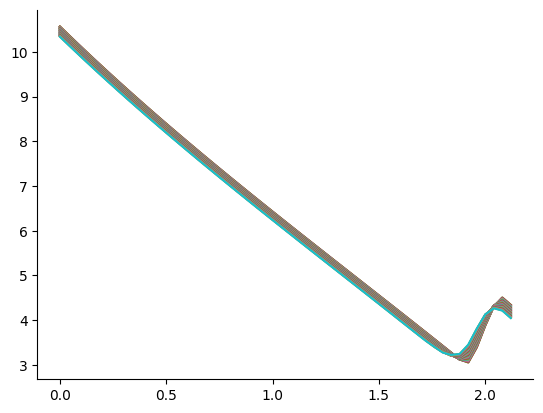

In [12]:
plt.plot(y1_grid_cap, ems)
plt.show()

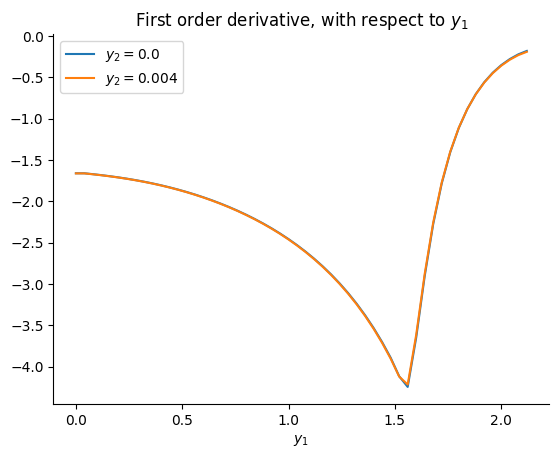

In [11]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

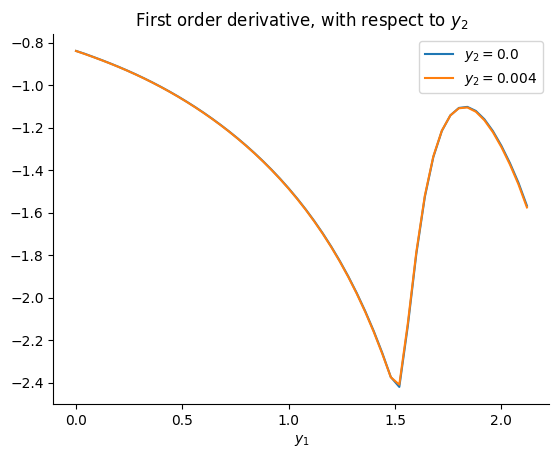

In [12]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

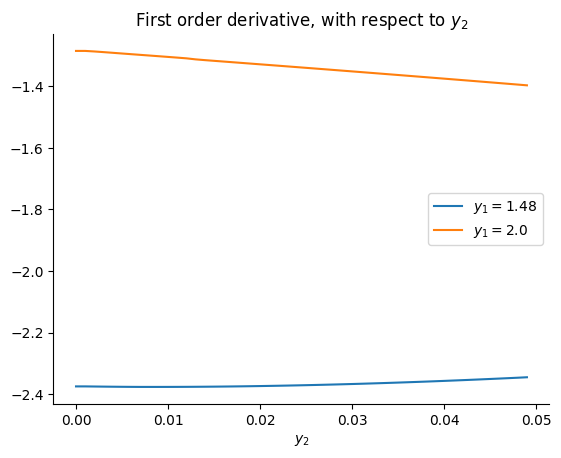

In [13]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

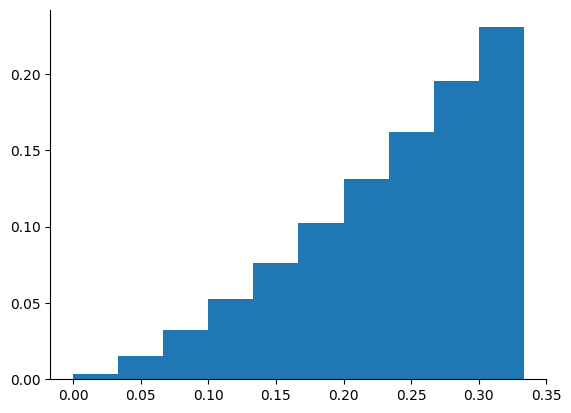

In [14]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

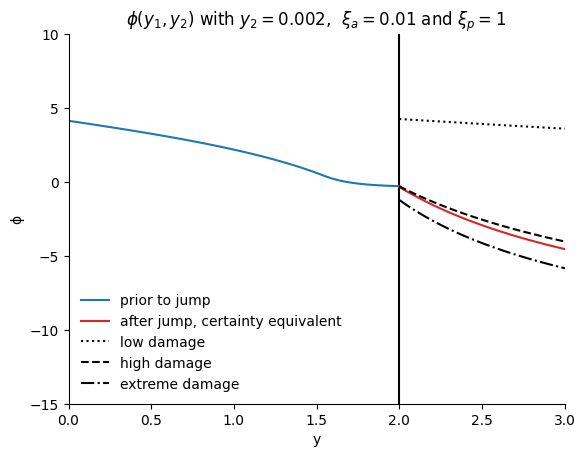

In [15]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

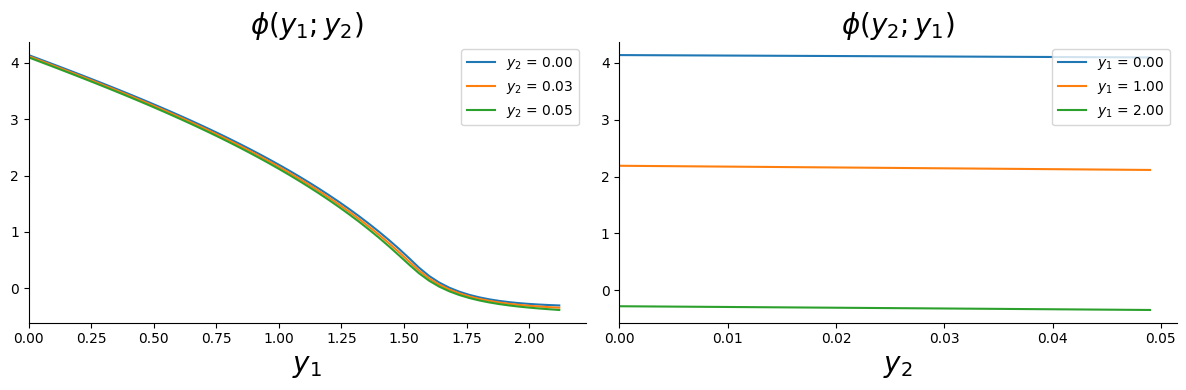

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

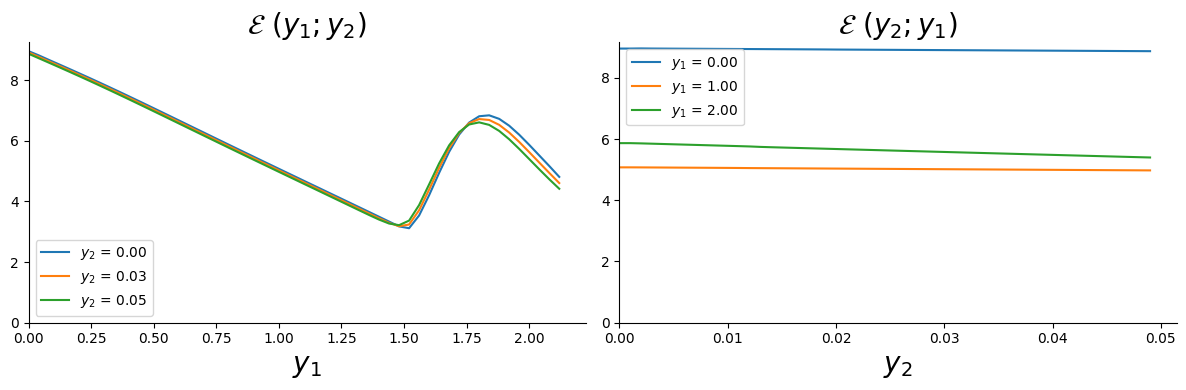

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [18]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [19]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [20]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [21]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [22]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

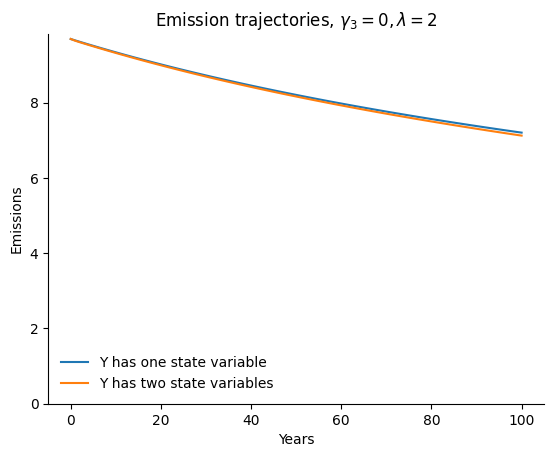

In [23]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [44]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=110
                                                 )

In [46]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open("simul_2", "wb"))

In [47]:
y1t_prejump

array([1.1       , 1.10778465, 1.11630198, 1.12486182, 1.13337288,
       1.14182344, 1.15021235, 1.15853984, 1.16680635, 1.17501235,
       1.18315829, 1.19124462, 1.19927176, 1.20724014, 1.2151501 ,
       1.22300204, 1.23079639, 1.23853358, 1.24621401, 1.25383811,
       1.26140628, 1.26891893, 1.27637647, 1.28377931, 1.29112785,
       1.29842248, 1.3056636 , 1.31285159, 1.31998684, 1.32706974,
       1.33410054, 1.34107959, 1.3480073 , 1.35488404, 1.36171017,
       1.36848607, 1.37521211, 1.38188863, 1.38851602, 1.39509463,
       1.40162482, 1.40810699, 1.41454161, 1.42092903, 1.4272696 ,
       1.43356365, 1.43981152, 1.44601353, 1.45217175, 1.45828671,
       1.46435873, 1.47038807, 1.47637499, 1.48231974, 1.4882334 ,
       1.4941343 , 1.50002491, 1.50590557, 1.51177631, 1.51763713,
       1.52348801, 1.52939438, 1.53541096, 1.54154764, 1.54780812,
       1.55419519, 1.56071155, 1.56736681, 1.57422201, 1.58129156,
       1.58858345, 1.59610493, 1.60386311, 1.61187521, 1.62016

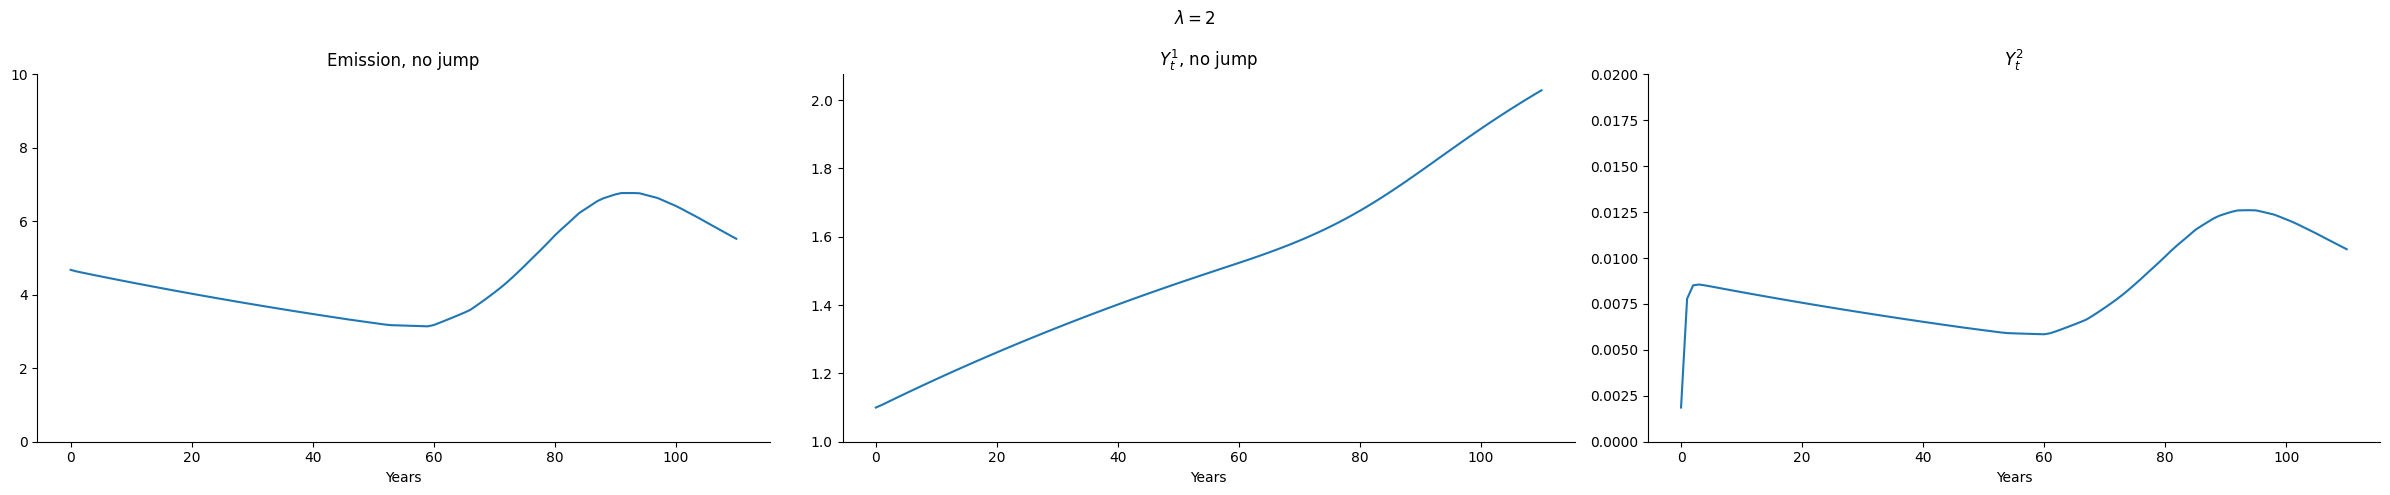

In [48]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [41]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

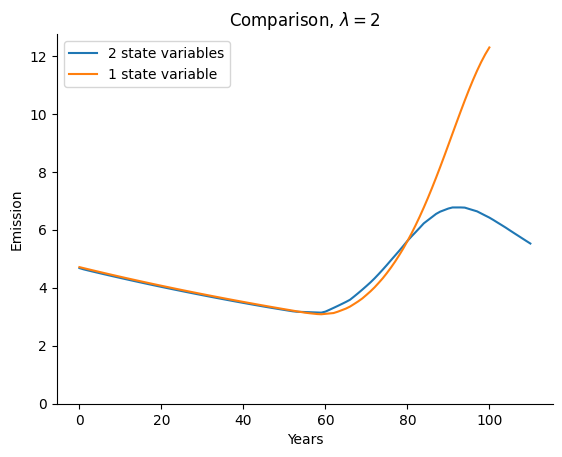

In [49]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [50]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [51]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [54]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=111)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

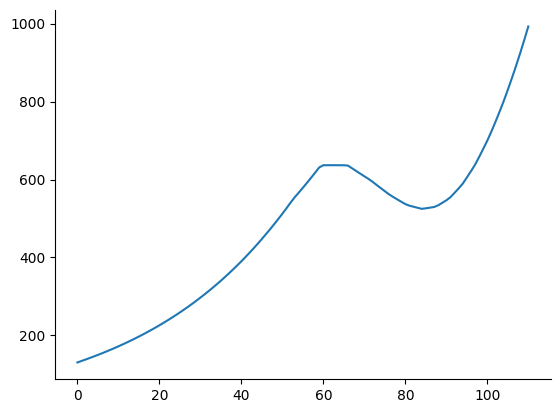

In [55]:
plt.plot(scc)
plt.show()

In [33]:
np.save(f"scct_{λ}", scc)